# ARIMA Forecasting Models

**A**uto-**R**egressive Integrated Moving Average models are effective tools for forecasting timeseries data. ARIMA modes are popular because they effectively model time series data by capturing both the autoregressive (AR) and moving average (MA) components, while also addressing non-stationarity through differencing (I). This combination makes ARIMA models especially flexible, which is why they are used across very different industries, like finance and weather prediction.

## Setup

Data & package setup steps. Run this first!

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Stationarity

_The distribution of the time series data does not change with time_. Modelling a timeseries with ARIMA _requires_ that the data are stationary (although non-stationary processes may often be transformed into stationary ones). Stationarity has 3 components:

### Zero Trend

The average trend of the data is neither positive nor negative.

/tmp/ipykernel_80047/2326579410.py:31: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  axes[1].plot(date_range, p(time_index), color='#4CAF50', linestyle='-', linewidth=2, label=f'Trend Line (Slope: {z[0]:.4f})')


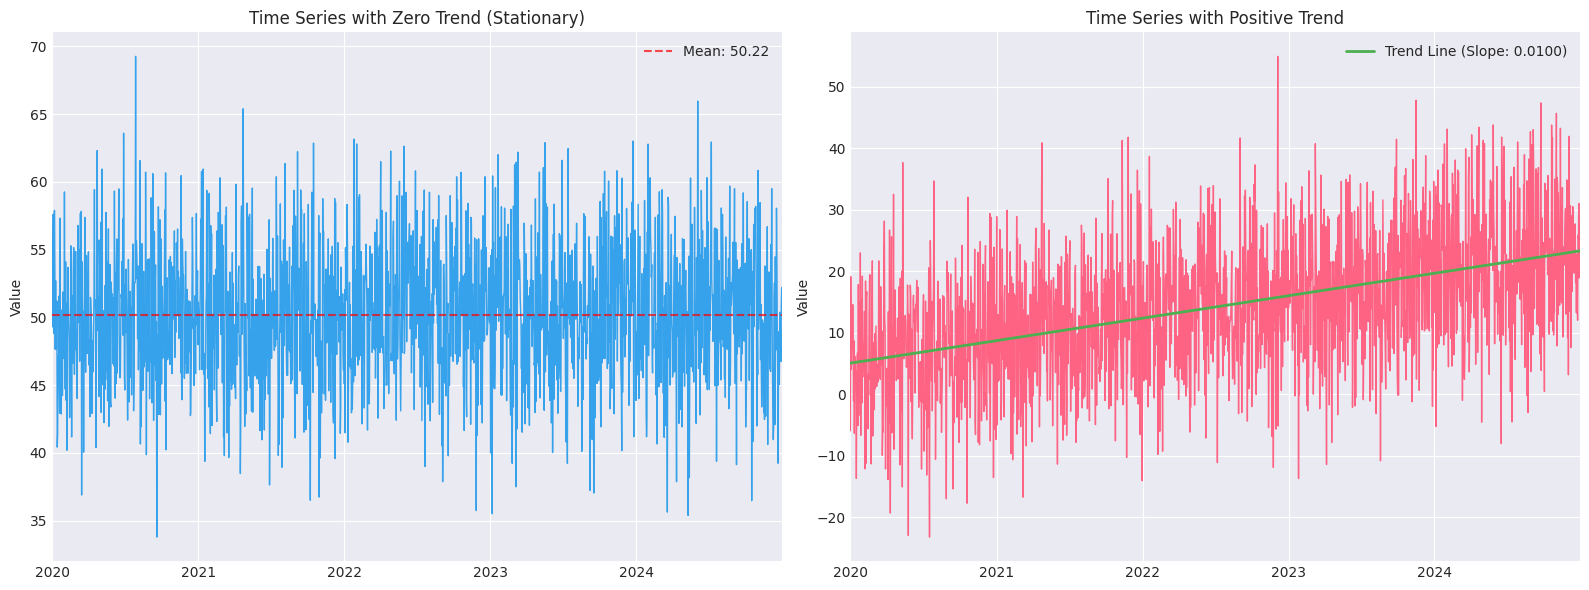

In [16]:
# Define the Date Range 
date_range = pd.date_range(start='2020-01-01', periods=1826, freq='D')

# Create Time Series Data with Zero Trend (Stationary)
np.random.seed(42) # for reproducibility
zero_trend_data = 50 + np.random.normal(loc=0, scale=5, size=len(date_range))
ts_zero_trend = pd.Series(zero_trend_data, index=date_range)

# This series is modeled as an increasing line (t/100) plus random noise (std=10).
time_index = np.arange(len(date_range))
positive_trend_data = (time_index / 100) + np.random.normal(loc=5, scale=10, size=len(date_range))
ts_positive_trend = pd.Series(positive_trend_data, index=date_range)

# Create a single figure with two subplots, arranged side-by-side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6)) #
plt.style.use('seaborn-v0_8-darkgrid')

# --- Plot 1: Zero Trend ---
ts_zero_trend.plot(ax=axes[0], title='Time Series with Zero Trend (Stationary)', color='#36A2EB', linewidth=1)
axes[0].set_ylabel('Value')
# Add a horizontal line to visualize the constant mean
axes[0].axhline(ts_zero_trend.mean(), color='red', linestyle='--', alpha=0.7, label=f'Mean: {ts_zero_trend.mean():.2f}')
axes[0].legend()

# --- Plot 2: Positive Trend ---
ts_positive_trend.plot(ax=axes[1], title='Time Series with Positive Trend', color='#FF6384', linewidth=1)
axes[1].set_ylabel('Value')
# Add a trend line (simple linear regression for visualization)
z = np.polyfit(time_index, ts_positive_trend.values, 1)
p = np.poly1d(z)
axes[1].plot(date_range, p(time_index), color='#4CAF50', linestyle='-', linewidth=2, label=f'Trend Line (Slope: {z[0]:.4f})')
axes[1].legend()

# Adjust layout to prevent subplot titles and labels from overlapping
plt.tight_layout() #
plt.show()

#### Augmented Dicky-Fuller Test

A test for _trend_ non-stationarity. The null hypothesis of this test is that the timeseries is _non-stationary_. This statistical test can be implemented with `statsmodels`:

In [21]:
from statsmodels.tsa.stattools import adfuller

def print_adfuller(
    adftest_result: tuple,
    title: str = "",
    crit_val_percent: str = '5',
) -> None:
    """
    Prints formatted results of the Augmented Dickey-Fuller (ADF) test,
    with an adjustable critical value for the conclusion.

    Args:
        adftest_result (tuple): The tuple returned by statsmodels.tsa.stattools.adfuller.
        title (str): An optional title for the results.
        crit_val_percent (str): The critical value percentage to use for the conclusion
                                (e.g., '1', '5', or '10'). Defaults to '5'.
    """
    print("="*60)
    if title:
        print(f"Augmented Dickey-Fuller Test Results: {title}")
    else:
        print("Augmented Dickey-Fuller Test Results:")
    print("="*60)

    # Extract results from the tuple
    adf_statistic = adftest_result[0]
    p_value = adftest_result[1]
    lags_used = adftest_result[2]
    n_observations = adftest_result[3]
    critical_values = adftest_result[4]

    # Print with headers
    print(f"ADF Test Statistic:      {adf_statistic:.5f}")
    print(f"P-value:                 {p_value:.5f}")
    print(f"Number of Lags Used:     {lags_used}")
    print(f"Number of Observations:  {n_observations}")

    print("\nCritical Values:")
    for key, value in critical_values.items():
        print(f"    {key:<10}: {value:.5f}")
    print("="*60)

    # Determine the conclusion based on the specified critical value
    key = f"{crit_val_percent}%"
    if key in critical_values:
        if adf_statistic < critical_values[key]:
            print(
                f"Conclusion: Reject the null hypothesis (H0) at the "
                f"{crit_val_percent}% significance level."
                f"\nThe time series is likely stationary."
            )
        else:
            print(
                f"Conclusion: Fail to reject the null hypothesis (H0) at the "
                f"{crit_val_percent}% significance level."
                f"\nThe time series is likely non-stationary."
            )
    else:
        print(f"Warning: Critical value for '{key}' not found in results.")
        if p_value <= (int(crit_val_percent) / 100):
            print("Conclusion based on P-value: Likely stationary.")
        else:
            print("Conclusion based on P-value: Likely non-stationary.")
    print("="*60)

print_adfuller(adfuller(ts_zero_trend), title="ADF Statistic for a Trend-Stationary Series")

Augmented Dickey-Fuller Test Results: ADF Statistic for a Trend-Stationary Series
ADF Test Statistic:      -42.76639
P-value:                 0.00000
Number of Lags Used:     0
Number of Observations:  1825

Critical Values:
    1%        : -3.43394
    5%        : -2.86313
    10%       : -2.56761
Conclusion: Reject the null hypothesis (H0) at the 5% significance level.
The time series is likely stationary.


In [23]:
print_adfuller(adfuller(ts_positive_trend), title="ADF Statistic for a Positive Trend Series")

Augmented Dickey-Fuller Test Results: ADF Statistic for a Positive Trend Series
ADF Test Statistic:      -2.72336
P-value:                 0.07008
Number of Lags Used:     25
Number of Observations:  1800

Critical Values:
    1%        : -3.43399
    5%        : -2.86315
    10%       : -2.56763
Conclusion: Fail to reject the null hypothesis (H0) at the 5% significance level.
The time series is likely non-stationary.


The more negative the ADF statistic, the more evidence the timeseries provides for rejecting the null-hypothesis (i.e., $H_0$: non-stationary trend). Remember that the augmented Dickey-Fuller _only_ tests for trend stationarity! It is possible for non-stationary series in terms of time-dependent variance, or dynamic auto-correlation; to pass the Dickey-Fuller.

### Constant Variance

The timeseries variance is not growing or shrinking with time.

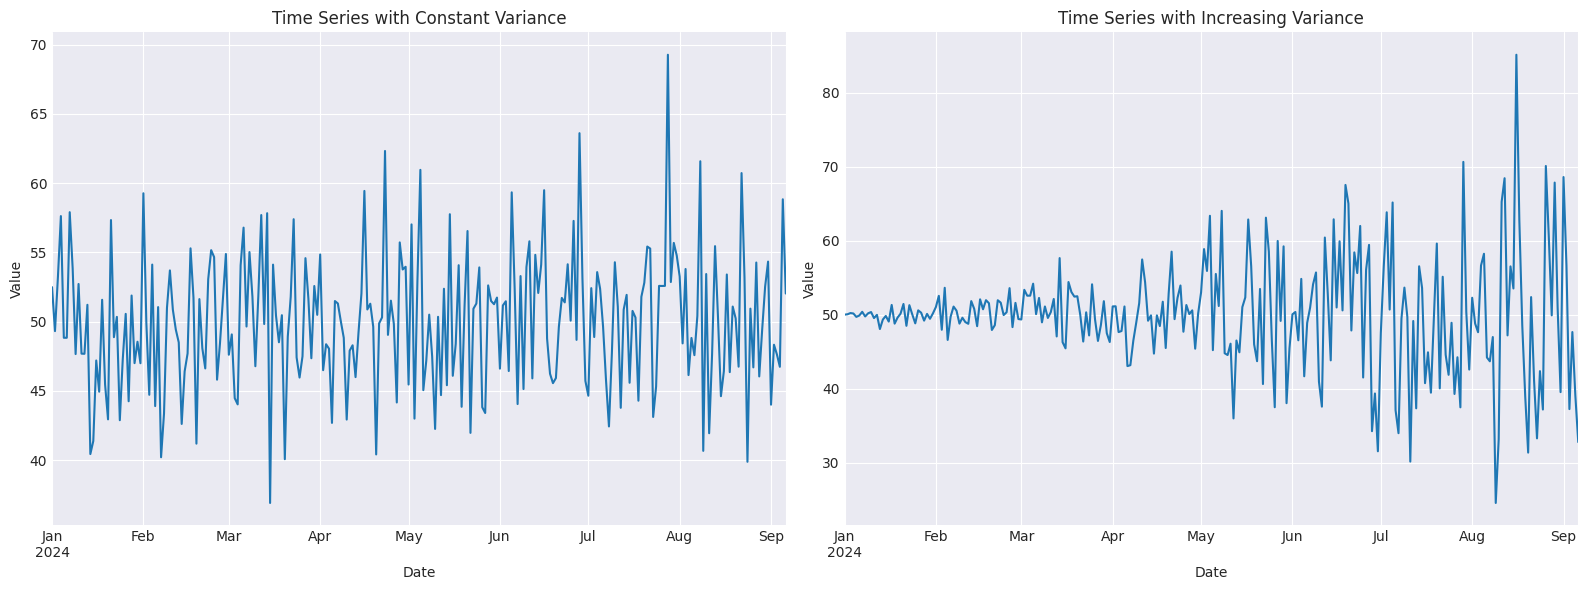

In [6]:
import numpy as np

# Generate data for a time series with constant variance
np.random.seed(42)  # For reproducibility
dates = pd.date_range(start='2024-01-01', periods=250, freq='D')
mean_level = 50
constant_variance_data = pd.Series(
    mean_level + np.random.normal(0, 5, size=len(dates)),
    index=dates
)

# Generate data for a time series with increasing variance
increasing_variance_data = pd.Series(
    mean_level + np.random.normal(0, np.arange(len(dates)) / 20, size=len(dates)),
    index=dates
)

# Create a DataFrame to hold both series
df = pd.DataFrame({
    'constant_variance': constant_variance_data,
    'increasing_variance': increasing_variance_data
})

# Plot the time series
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Plot the constant variance time series
df['constant_variance'].plot(ax=axes[0], title='Time Series with Constant Variance')
axes[0].set_ylabel('Value')
axes[0].set_xlabel('Date')

# Plot the increasing variance time series
df['increasing_variance'].plot(ax=axes[1], title='Time Series with Increasing Variance')
axes[1].set_ylabel('Value')
axes[1].set_xlabel('Date')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### Constant Auto-Correlation

The relationship between timeseries values at time $t$ and $t-n$ remains a constant factor.

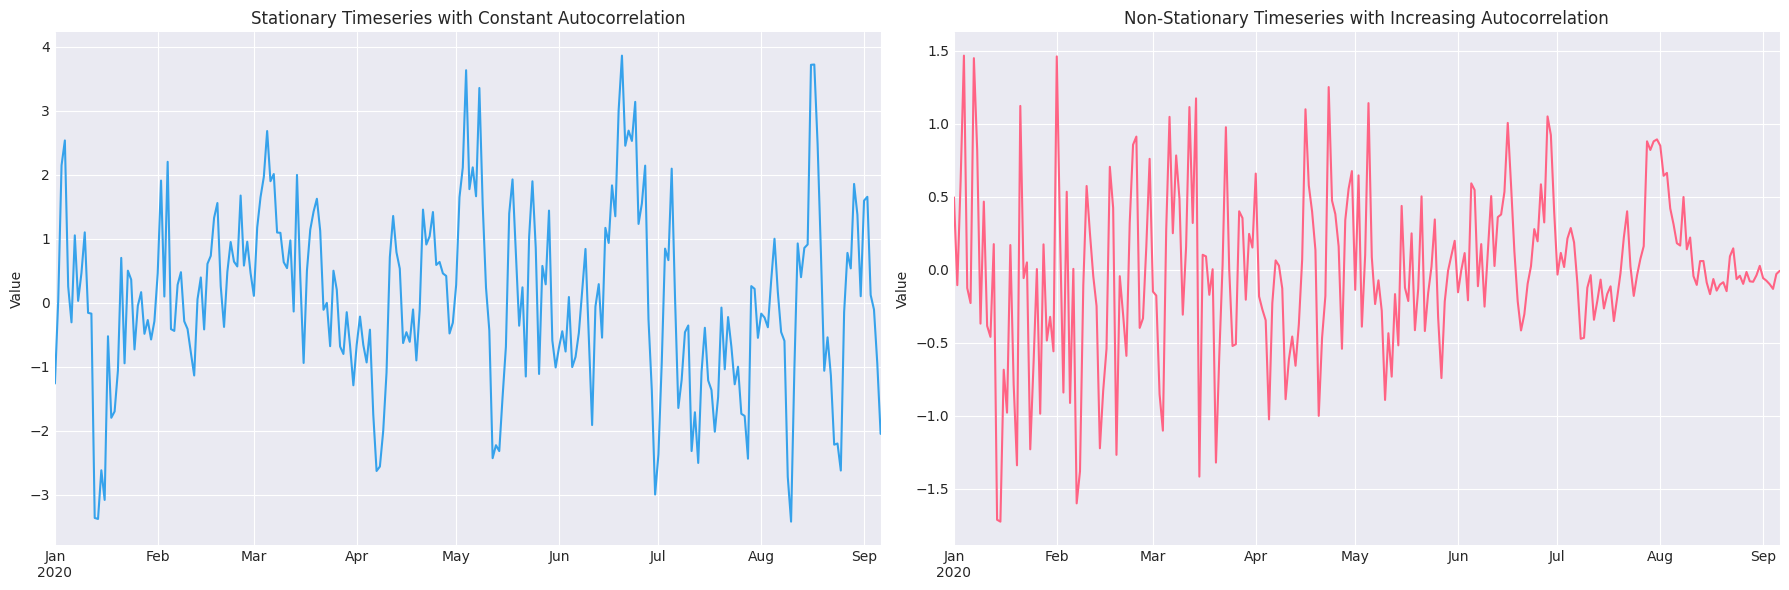

In [13]:
from statsmodels.tsa.arima_process import ArmaProcess

# Use a consistent plotting style
plt.style.use('seaborn-v0_8-darkgrid')

# Define a date range for the time series
prd_len = 250
dates = pd.date_range(start='2020-01-01', periods=prd_len, freq='D')

# --- Time Series with Constant Autocorrelation (AR(1) Process) ---
# For a simple AR(1) process, the moving-average component is 1.
ar_params_const = [1, -0.7]  # Coefficient for lag 1 is -0.7
ma_params_const = [1]
ar_const_process = ArmaProcess(ar_params_const, ma_params_const)
ts_const_ac = pd.Series(ar_const_process.generate_sample(nsample=prd_len, scale=1.0), index=dates)

# --- Time Series with Increasing Autocorrelation ---
# Initialize the series with some noise
np.random.seed(42)
ts_increasing_ac_list = [np.random.normal(0, 1)]

# Loop to build the series with an increasing autocorrelation coefficient
alpha = np.linspace(0.05, 0.95, prd_len)
for i in range(1, prd_len):
    # Current value is a combination of the previous value (with increasing weight)
    # and a new random noise term.
    new_val = alpha[i] * ts_increasing_ac_list[-1] + (1 - alpha[i]) * np.random.normal(0, 1)
    ts_increasing_ac_list.append(new_val)

# Convert the list to a Pandas Series with the date index before plotting
ts_increasing_ac = pd.Series(ts_increasing_ac_list, index=dates)

# --- Plot the Time Series side-by-side ---
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Plot 1: Constant Autocorrelation Time Series
ts_const_ac.plot(ax=axes[0], color='#36A2EB')
axes[0].set_title('Stationary Timeseries with Constant Autocorrelation')
axes[0].set_ylabel('Value')

# Plot 2: Increasing Autocorrelation Time Series
ts_increasing_ac.plot(ax=axes[1], color='#FF6384')
axes[1].set_title('Non-Stationary Timeseries with Increasing Autocorrelation')
axes[1].set_ylabel('Value')

plt.tight_layout()
plt.show()


### Transforming Non-Stationary Series into Stationary Ones

In order to use an ARIMA model to forecast non-stationary series, we must first transform the timeseries into a stationary one. The are many types of tranforms, although luckily the simplest (i.e., differences) is often the best:

* Differencing: subtract the prior value from each value in a timeseries: $\dot{y}_{t} = y_t - y_{t-1}$
* Logging:.... FILL OUT

The following uses differencing to make-stationary a population growth trend Salt Lake City. First, observe the non-stationary growth of people in the Salt Lake City metropolitan area:

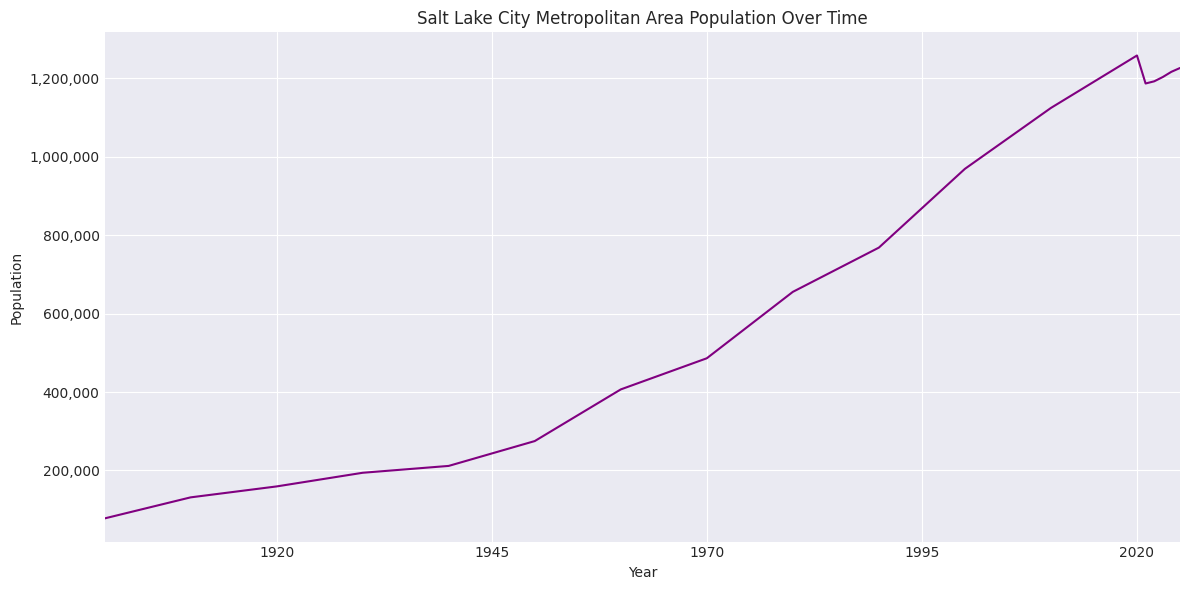

In [54]:
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

# Load the data and ensure correct data types
slc_pop_df = pd.read_csv(
    'DATA/salt_lake_city_population.csv'
)

#Correctly parse the 'Year' column using pd.to_datetime with format='%Y'
slc_pop_df['Year'] = pd.to_datetime(slc_pop_df['Year'], format='%Y')
slc_pop_df.set_index('Year', inplace=True)

# Create the plot using pandas, and get the matplotlib axes object
fig, ax = plt.subplots(figsize=(12, 6))

slc_pop_df.plot(
    ax=ax,
    title='Salt Lake City Metropolitan Area Population Over Time',
    legend=False,
    color='purple'
)

# Define a function to format the y-axis (population) into thousands.
def formatter(x, pos):
    """Formats a number with a thousands separator."""
    return f"{x:,.0f}"

# Apply the formatter to the y-axis and set the label.
ax.yaxis.set_major_formatter(ticker.FuncFormatter(thousands_formatter))
ax.set_ylabel('Population')
ax.set_xlabel('Year')

# Ensure a clean layout and display the final plot.
plt.grid(True)
plt.tight_layout()
plt.show()

The above population growth series has a clear growth trend that is non-stationary. Simply taking a difference of this growth trend will magically transform the series into a stationary one:

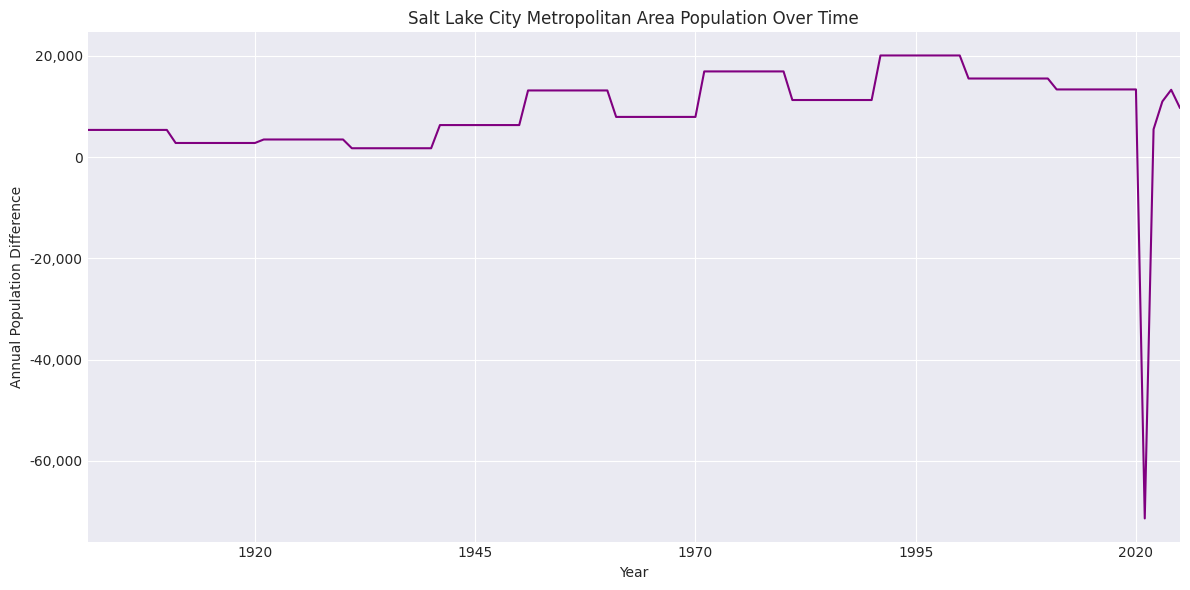

In [58]:
slc_pop_df['pop_diff'] = slc_pop_df.Population.diff()

# Create the plot using pandas, and get the matplotlib axes object
fig, ax = plt.subplots(figsize=(12, 6))

slc_pop_df.pop_diff.dropna().plot(
    ax=ax,
    title='Salt Lake City Metropolitan Area Population Over Time',
    legend=False,
    color='purple'
)

# Apply the formatter to the y-axis and set the label.
ax.yaxis.set_major_formatter(ticker.FuncFormatter(thousands_formatter))
ax.set_ylabel('Annual Population Difference')
ax.set_xlabel('Year')

# Ensure a clean layout and display the final plot.
plt.grid(True)
plt.tight_layout()
plt.show()


This time, taking a single difference was enough to make it stationary. But, other timeseries may require _multiple_ differences, or other transformation methods to become stationary.

## The Components of ARIMA

### Auto Regressive

Put simply, future values are modelled as dependent on past values. An auto-regressive model uses lagged time values of an outcome variable ($y$) as _predictors_ of $y$ at time $t$. 

$$
y_t = \beta_0 + \beta_1y_{t-1} + \beta_2y_{t-2} + \dots + \beta_ny_{t-n} + \epsilon
$$

## ARIMA Term Definitions

* **Trend**: The average slope over a given time period
* **Seasonality**: Patterns of variation that repeat across fixed periods (e.g., daily, weekly, etc.)
* **Cyclicality**: A repeating pattern of variation but without a fixed period
* **White Noise**: A series whose values have a mean of zero, constant variance (maybe), and are not auto-correlated across time
